# Loading dataset

In [ ]:
# Install required libraries
!pip install numpy
!pip install pandas
!pip install torch
!pip install tqdm
!pip install matplotlib
!pip install transformers
!pip install sklearn
!pip install tqdm
!pip install matplotlib==3.5.0

In [ ]:
# We start by importing libraries that we will be making use of in the assignment.
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
import tqdm
import re
import seaborn as sns

In [107]:
df= pd.read_csv("./all_tickets.csv")
df.shape

(48549, 9)

In [ ]:
df.sample(5)

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
46480,social error,sent monday december error dear please with fo...,0,4,21,41,40,1,3
39489,please advise how can proceed with submitted the,please advise how can proceed with submitted h...,0,4,21,41,67,2,3
5909,leaver leave date october location centre,leaver form leave date october location centre...,1,4,2,51,56,3,4
16949,new cost center systems,thursday pm cost center hi according latest gu...,1,4,3,21,68,3,4
31322,chief data officer transforming the,wednesday pm chief officer transforming hi guy...,1,4,3,21,89,3,4


# EDA

In [108]:
df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [109]:
#Looking at number of unique classes in each of the target feature
print("FEATURE".ljust(17),"|","NUMBER OF CLASSES")
print("--------------------------------------")
for col in df.iloc[:,2:]:
    print(col.ljust(17),":", len(df[col].unique()))

FEATURE           | NUMBER OF CLASSES
--------------------------------------
ticket_type       : 2
category          : 13
sub_category1     : 59
sub_category2     : 115
business_service  : 103
urgency           : 4
impact            : 5


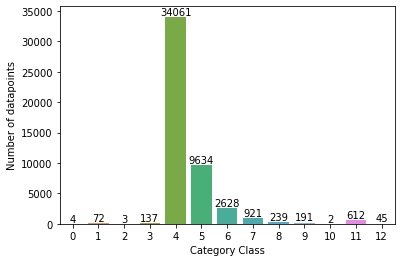

In [110]:
#Plotting category distribution
col = "category"
data = df.groupby(col).count().reset_index()
ax = sns.barplot(x=col, y='body',
                data=data,
                errwidth=0)
ax.set_ylabel("Number of datapoints")
ax.set_xlabel("Category Class")
for i in ax.containers:
    ax.bar_label(i,)

We will use 'category' as our target variable

In [111]:
df = df[["title", "body", "category"]]

In [113]:
#Number of Nan Values
print("Number of Nan Values\n")
print(f'Title Column:{df["title"].isnull().sum()}\nBody Column:{df["body"].isnull().sum()}')

Number of Nan Values

Title Column:712
Body Column:0


In [114]:
#filling nan in Title with blank string
df["title"].fillna(" ",inplace = True)
#Verifying
print("Number of Nan Values\n")
print(f'Title Column:{df["title"].isnull().sum()}\nBody Column:{df["body"].isnull().sum()}')

Number of Nan Values

Title Column:0
Body Column:0


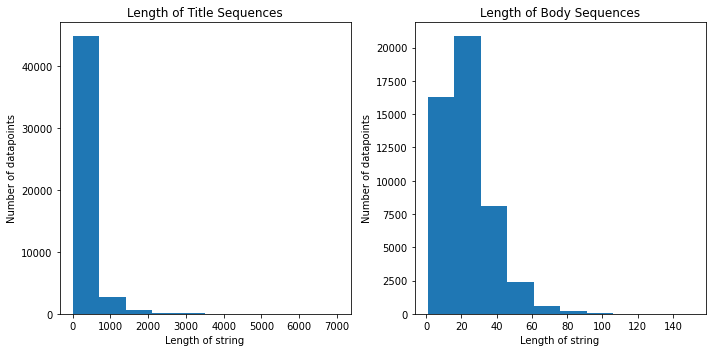

In [115]:
#Analysing length of sequences in Title and Body column
fig = plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.hist(df["body"].apply(len))
ax1.set_xlabel("Length of string")
ax1.set_ylabel("Number of datapoints")
ax2.hist(df["title"].apply(len))
ax2.set_xlabel("Length of string")
ax2.set_ylabel("Number of datapoints")
ax1.title.set_text('Length of Title Sequences')
ax2.title.set_text('Length of Body Sequences')
fig.tight_layout()
plt.show()

# Preprocessing

In [116]:
#Removing Special characters
import re
pattern = r'[^A-Za-z0-9 ]+'

In [117]:
df['title'] =  [re.sub(pattern,'', str(x)) for x in df['title']]
df['body'] =  [re.sub(pattern,'', str(x)) for x in df['body']]

In [118]:
#Changing content to lower case
df["title"] = df["title"].str.lower()
df["body"] = df["body"].str.lower()

In [120]:
#Taking top five categories in terms of number of datapoints
df_filtered = df.loc[(df.category.isin([4,5,6,7,11]))]

In [121]:
df_filtered.head()

,title,body,category
0,,hi since recruiter lead permission approve req...,4
1,connection with icon,icon dear please setup icon per icon engineers...,6
2,work experience user,work experience user hi work experience studen...,5
3,requesting for meeting,requesting meeting hi please help follow equip...,5
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,4


In [122]:
df_filtered.groupby("category").count()

,title,body
category,,
4,34061,34061
5,9634,9634
6,2628,2628
7,921,921
11,612,612


In [123]:
#creating dict to redefine labels from 0 to 4
new_cat = {4: 0, 5:1, 6:2, 7:3, 11:4}

In [124]:
df_filtered.replace({"category": new_cat},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
#Splitting data into test and train
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_filtered, test_size = 0.2,\
                                     stratify = df_filtered["category"],\
                                     random_state = 42, shuffle = True)

In [ ]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
print(train_df.groupby("category").count())
print(test_df.groupby("category").count())

          title   body
category              
0         27248  27248
1          7707   7707
2          2102   2102
3           737    737
4           490    490
          title  body
category             
0          6813  6813
1          1927  1927
2           526   526
3           184   184
4           122   122


In [ ]:
# We reserve 20% of the training data for validation
test_df, val_df = train_test_split(test_df, test_size=0.2, random_state = 42)
print(f"Number of Training Examples: {len(train_df)}")
print(f"Number of Validation Examples: {len(val_df)}")
print(f"Number of Test Examples: {len(test_df)}")

Number of Training Examples: 38284
Number of Validation Examples: 1915
Number of Test Examples: 7657


## Tokenization using BERT

In [48]:
# Import the BertTokenizer from the library
from transformers import BertTokenizer

# Load a pre-trained BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

## Defining Dataloader


In [46]:
from torch.utils.data import Dataset, DataLoader

class BertDataset(Dataset):
    
    def __init__(self, sentences, labels, seq_len = 150, bert_variant = "bert-base-uncased"):
        """
        Constructor for the `BertDataset` class. Stores the `sentences` and `labels` which can then be used by
        other methods. Also initializes the tokenizer
        
        Inputs:
            - sentences (list) : A list of movie reviews
            - labels (list): A list of sentiment labels corresponding to each review
            - seq_len (int): Length of the sequence to use.
                             If number of tokens are lower than `seq_len` add padding otherwise truncate
        """

        self.sentences = sentences
        self.labels = labels
        self.seq_len = seq_len
        self.tokenizer = BertTokenizer.from_pretrained(bert_variant)
        
        
    def __len__(self):
        """
        Returns the length of the dataset i.e. the number of datapoints present in 
        the dataset
        """
        length = None
        
        length = len(self.sentences)
        
        return length
    
    def __getitem__(self, idx):
        """
        Returns the training example corresponding to datapoints present at the 
        `idx` position in the dataset
        
        Inputs:
            - idx (int): Index corresponding to the review,label to be returned
            
        Returns:
            - input_ids (torch.tensor): Indices of the tokens in the sentence 
                                        at `idx` position.
                                        Shape of the tensor should be (`seq_len`,)
            - mask (torch.tensor): Attention mask indicating which tokens are padded.
                                   Shape of the tensor should be (`seq_len`,)
            - label (int): label for the corresponding sentence
        
        """
        

        tokenizer_output = self.tokenizer(self.sentences[idx],\
                                          max_length=self.seq_len, \
                                          padding="max_length", \
                                          truncation = True, return_tensors="pt")
        input_ids = tokenizer_output["input_ids"]
        mask = tokenizer_output["attention_mask"]
        label = self.labels[idx]
        
        return input_ids.squeeze(0), mask.squeeze(0), torch.tensor(label)

In [ ]:
#Concatenating title and body columns 
train_df["combined"] = train_df["title"] + train_df["body"]
test_df["combined"] = test_df["title"] + test_df["body"]
val_df["combined"] = val_df["title"] + val_df["body"]

In [ ]:
#Creating a balanced train data by sampling equally from all classes
n_sample = 490
balanced_df = train_df.loc[train_df.category == 0].sample(n_sample)
for i in range(1,5):
  balanced_df = pd.concat([balanced_df, train_df.loc[train_df.category == i].sample(n_sample)])

In [ ]:
print(balanced_df.groupby("category").count())

          title  body  ohe_cat  combined
category                                
0           490   490      490       490
1           490   490      490       490
2           490   490      490       490
3           490   490      490       490
4           490   490      490       490


In [ ]:
seq_len = 150
batch_size = 32

train_sentences, train_labels = balanced_df["combined"].values, balanced_df["category"].values
val_sentences, val_labels = val_df["combined"].values, val_df["category"].values
test_sentences, test_labels = test_df["combined"].values, test_df["category"].values

train_dataset = BertDataset(train_sentences, train_labels, seq_len=seq_len)
val_dataset = BertDataset(val_sentences, val_labels, seq_len=seq_len)
test_dataset = BertDataset(test_sentences, test_labels, seq_len=seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Baseline Model: Implementing and Training BERT-based Classifier

Similar to pretrained tokenizers, the transformers library also provide numerous pre-trained language models that can be fine-tuned on a wide variety of downstream tasks. We demonstrate usage of these models below.

In [42]:
# Import BertModel from the library
from transformers import BertModel

# Create an instance of pretrained BERT
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
class BertClassifierModel(nn.Module):
    
    def __init__(self, d_hidden = 768, bert_variant = "bert-base-uncased"):
        """
        We defined 3 components, first a BERT layer
        using `BertModel` from transformers library,
        a linear layer to map the representation from Bert to the output,
        and a softmax layer to map the score to a proability
        
        Inputs:
            - d_hidden (int): Size of the hidden representations of bert
            - bert_variant (str): BERT variant to use
        """
        super(BertClassifierModel, self).__init__()
        output_dim = 5
        self.bert_layer = BertModel.from_pretrained(bert_variant)
        self.output_layer = nn.Linear(d_hidden, output_dim)
        self.softmax_layer = nn.LogSoftmax()
        
        
    def forward(self, input_ids, attn_mask):
        """
        Forward Passes the inputs through the network and obtains the prediction
        
        Inputs:
            - input_ids (torch.tensor): A torch tensor of shape [batch_size, seq_len]
                                        representing the sequence of token ids
            - attn_mask (torch.tensor): A torch tensor of shape [batch_size, seq_len]
                                        representing the attention mask such that padded tokens are 0 and rest 1
                                        
        Returns:
          - output (torch.tensor): A torch tensor of shape [batch_size,] obtained after passing the input to the network
                                        
        """
        bert_output = self.bert_layer(input_ids, attention_mask = attn_mask)
        sentence_embedding = bert_output.pooler_output
        output = self.softmax_layer(self.output_layer(sentence_embedding))

        
        return output.squeeze(-1) 

###Training and Evaluating the Model

In [ ]:
def evaluate(model, test_dataloader, threshold = 0.5, device = "cpu"):
    """
    Evaluates `model` on test dataset

    Inputs:
        - model (BertClassifierModel): model to be evaluated
        - test_dataloader (torch.utils.DataLoader): A dataloader defined over the test dataset
        - threshold (float): Probability Threshold above which we consider label as 1 and 0 below

    Returns:
        - accuracy (float): Average accuracy over the test dataset 
    """

    model.to(device)
    model = model.eval() # Set model to evaluation model 
    accuracy = 0
    bucket_pred = []
    bucket_label = []
    # by specifying `torch.no_grad`, it ensures no gradients are calcuated while running the model,
    # this makes the computation much more faster
    with torch.no_grad():
      for test_batch in test_dataloader:
        input_ids, attention_mask, labels = test_batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.float().to(device)
        labels = labels.float().to(device)

        # Step 1: Get probability predictions from the model and store it in `pred_probs`
        pred_probs = model(input_ids, attention_mask)

        x_ = torch.topk(pred_probs,1).indices
        y_ = labels
        bucket_pred += x_.detach().tolist()
        bucket_label+= y_.detach().tolist()
        s = 0
        for i in range(len(x_)):
          if x_[i] == y_[i]:
            s+=1
        batch_accuracy = s/len(x_)

        accuracy += batch_accuracy

      # Divide by number of batches to get average accuracy
      accuracy = accuracy / len(test_dataloader)

      return accuracy,np.array(bucket_pred).flatten(), np.array(bucket_label).flatten()

def train(model, train_dataloader, val_dataloader,
          lr = 1e-5, num_epochs = 3,
          device = "cpu"):
    """
    Runs the training loop. 

    Inputs:
        - model (BertClassifierModel): BERT based classifer model to be trained
        - train_dataloader (torch.utils.DataLoader): A dataloader defined over the training dataset
        - val_dataloader (torch.utils.DataLoader): A dataloader defined over the validation dataset
        - lr (float): The learning rate for the optimizer
        - num_epochs (int): Number of epochs to train the model for.
        - device (str): Device to train the model on. Can be either 'cuda' (for using gpu) or 'cpu'

    Returns:
        - best_model (BertClassifierModel): model corresponding to the highest validation accuracy (checked at the end of each epoch)
        - best_val_accuracy (float): Validation accuracy corresponding to the best epoch
    """
    epoch_loss = 0
    model = model.to(device)
    
    best_val_accuracy = float("-inf")
    best_model = None
    
    # 1. Define Loss function and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = Adam(model.parameters(), lr = lr)

    epoch_loss_bucket = []
    for epoch in range(num_epochs):
        model.train() # Since we are evaluating model at the end of every epoch, it is important to bring it back to train mode
        epoch_loss = 0
        
        # 2. Write Training Loop

        for train_batch in tqdm.tqdm(train_dataloader):
          optimizer.zero_grad()
          input_ids, attention_mask, labels = train_batch

          input_ids = input_ids.to(device)
          labels = labels.type(torch.LongTensor).to(device)
          attention_mask = attention_mask.float().to(device)
          preds=model(input_ids, attention_mask)

          loss = loss_fn(preds, labels)

          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

        
        epoch_loss = epoch_loss / len(train_dataloader)
        epoch_loss_bucket.append(epoch_loss)
        # 3. Evaluate on validation data by calling `evaluate` and store the validation accuracy in `val_accurracy`
        val_accuracy = 0

        val_accuracy,_,_ = evaluate(model, val_dataloader, device ="cuda")
        
        # Model selection
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model) # Create a copy of model
        
        print(f"Epoch {epoch} completed | Average Training Loss: {epoch_loss} | Validation Accuracy: {val_accuracy}")
    plt.plot(epoch_loss_bucket)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("Training Loss")
    plt.show()
    return best_model, best_val_accuracy

Training on 100 data points for sanity check


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 25/25 [00:01<00:00, 12.63it/s]


Epoch 0 completed | Average Training Loss: 1.3403569269180298 | Validation Accuracy: 0.66


100%|██████████| 25/25 [00:01<00:00, 13.26it/s]


Epoch 1 completed | Average Training Loss: 1.0672068047523497 | Validation Accuracy: 0.66


100%|██████████| 25/25 [00:01<00:00, 13.61it/s]


Epoch 2 completed | Average Training Loss: 0.9581402373313904 | Validation Accuracy: 0.66


100%|██████████| 25/25 [00:01<00:00, 13.36it/s]


Epoch 3 completed | Average Training Loss: 0.8789463639259338 | Validation Accuracy: 0.81


100%|██████████| 25/25 [00:01<00:00, 13.21it/s]


Epoch 4 completed | Average Training Loss: 0.7130244576931 | Validation Accuracy: 0.89


100%|██████████| 25/25 [00:01<00:00, 13.27it/s]


Epoch 5 completed | Average Training Loss: 0.5650871336460114 | Validation Accuracy: 0.93


100%|██████████| 25/25 [00:01<00:00, 13.42it/s]


Epoch 6 completed | Average Training Loss: 0.48370532155036927 | Validation Accuracy: 0.91


100%|██████████| 25/25 [00:01<00:00, 13.35it/s]


Epoch 7 completed | Average Training Loss: 0.3797323355078697 | Validation Accuracy: 0.91


100%|██████████| 25/25 [00:01<00:00, 13.43it/s]


Epoch 8 completed | Average Training Loss: 0.3694636386632919 | Validation Accuracy: 0.93


100%|██████████| 25/25 [00:01<00:00, 13.59it/s]


Epoch 9 completed | Average Training Loss: 0.30144013017416 | Validation Accuracy: 0.94


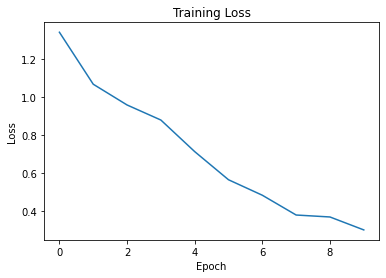

Best Validation Accuracy: 0.94
Expected Best Validation Accuracy: 0.99


In [ ]:
torch.manual_seed(42)
print("Training on 100 data points for sanity check")
sample_sentences = train_df["title"].values.tolist()[:100]
sample_labels = train_df["category"].values.tolist()[:100]
sample_dataset = BertDataset(sample_sentences, sample_labels, seq_len=32)
sample_dataloader = DataLoader(sample_dataset, batch_size=4)

model = BertClassifierModel()
best_model, best_val_acc = train(model, sample_dataloader, sample_dataloader, num_epochs = 10, device = "cuda")
print(f"Best Validation Accuracy: {best_val_acc}")
print(f"Expected Best Validation Accuracy: {0.99}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 77/77 [00:41<00:00,  1.88it/s]


Epoch 0 completed | Average Training Loss: 0.94353018023751 | Validation Accuracy: 0.7127700617283951


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 1 completed | Average Training Loss: 0.8626256383858718 | Validation Accuracy: 0.7127700617283951


100%|██████████| 77/77 [00:41<00:00,  1.87it/s]


Epoch 2 completed | Average Training Loss: 0.8554300967749063 | Validation Accuracy: 0.7127700617283951


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 3 completed | Average Training Loss: 0.8385733079600644 | Validation Accuracy: 0.7127700617283951


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 4 completed | Average Training Loss: 0.8055943397732525 | Validation Accuracy: 0.7122492283950617


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 5 completed | Average Training Loss: 0.7352253272161855 | Validation Accuracy: 0.703395061728395


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 6 completed | Average Training Loss: 0.6204967680689576 | Validation Accuracy: 0.6729938271604937


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 7 completed | Average Training Loss: 0.6083463325903014 | Validation Accuracy: 0.6114390432098766


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 8 completed | Average Training Loss: 0.49748135329066934 | Validation Accuracy: 0.6170717592592593


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 9 completed | Average Training Loss: 0.41490356314491916 | Validation Accuracy: 0.5337384259259259


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 10 completed | Average Training Loss: 0.35467628476681645 | Validation Accuracy: 0.45271990740740736


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 11 completed | Average Training Loss: 0.36393384790265715 | Validation Accuracy: 0.6118634259259259


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 12 completed | Average Training Loss: 0.2952705087599816 | Validation Accuracy: 0.575733024691358


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 13 completed | Average Training Loss: 0.26937434599771126 | Validation Accuracy: 0.580324074074074


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 14 completed | Average Training Loss: 0.2241001453299027 | Validation Accuracy: 0.600636574074074


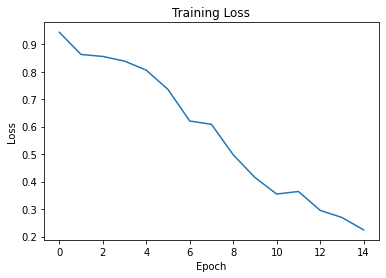

In [ ]:
model = BertClassifierModel()
best_model, best_val_acc = train(model, train_loader, val_loader, num_epochs = 15, device = "cuda")

100%|██████████| 77/77 [00:41<00:00,  1.88it/s]


Epoch 0 completed | Average Training Loss: 0.06845479604316415 | Validation Accuracy: 0.6353973765432099


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 1 completed | Average Training Loss: 0.06006138814105229 | Validation Accuracy: 0.6714313271604938


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 2 completed | Average Training Loss: 0.05623973122882572 | Validation Accuracy: 0.6572723765432099


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 3 completed | Average Training Loss: 0.04839249633784805 | Validation Accuracy: 0.6266782407407407


100%|██████████| 77/77 [00:40<00:00,  1.88it/s]


Epoch 4 completed | Average Training Loss: 0.04846050269756611 | Validation Accuracy: 0.6850694444444444


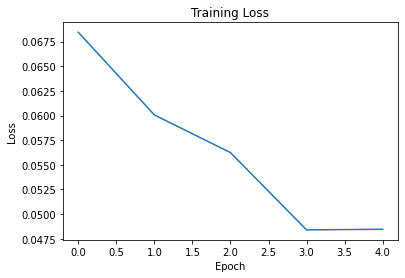

In [ ]:
#We trained same model for five more epochs
best_model, best_val_acc = train(model, train_loader, val_loader, num_epochs = 5, device = "cuda")

In [ ]:
test_accuracy,bucket_pred,bucket_label = evaluate(best_model, test_loader, threshold = 0.5, device = "cuda")
print(test_accuracy)

0.699001736111111


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(bucket_label, bucket_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.94      0.81      5448
         1.0       0.30      0.08      0.13      1548
         2.0       0.06      0.01      0.02       426
         3.0       0.06      0.01      0.02       135
         4.0       0.05      0.01      0.02       100

    accuracy                           0.68      7657
   macro avg       0.24      0.21      0.20      7657
weighted avg       0.58      0.68      0.61      7657



Model has a moderate performance with poor recall and precision on minority classes. High accuracy towards the majority class indicate that model has not generalised effectively and remains biased towards majority class. 

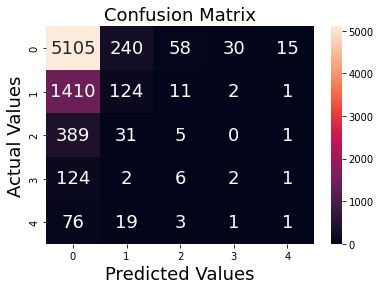

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(bucket_label, bucket_pred)
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])
#Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 18}, fmt='.0f')
plt.title('Confusion Matrix', fontsize = 18)
plt.ylabel('Actual Values', fontsize = 18)
plt.xlabel('Predicted Values', fontsize = 18)
plt.show()

# Method 2 : Handling Large Sequence Length

In [140]:
#Concatenating title and body columns for the whole dataset
df_filtered["combined"] = df_filtered["title"] +" "+ df_filtered["body"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [141]:
df_filtered.head()

,title,body,category,combined,index
0,,hi since recruiter lead permission approve req...,0,hi since recruiter lead permission approve r...,0
1,connection with icon,icon dear please setup icon per icon engineers...,2,connection with icon icon dear please setup ic...,1
2,work experience user,work experience user hi work experience studen...,1,work experience user work experience user hi w...,2
3,requesting for meeting,requesting meeting hi please help follow equip...,1,requesting for meeting requesting meeting hi p...,3
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,0,reset passwords for external accounts re expir...,4


In [130]:
#Creating explicit index column which will be useful during pooling operation
df_filtered["index"] = list(df_filtered.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [143]:
df_raw = df_filtered[["index", "combined", "category"]]

In [164]:
#Dividing dataset into two dataframes based on sequence length. 
#This is done to segregate large sentences which will be divided into smaller chunks. 
df_large_seq = df_filtered.loc[(df_filtered.combined.apply(len) > seq_len)]
df_small_seq = df_filtered.loc[(df_filtered.combined.apply(len) <= seq_len)]

In [165]:
#Function to break a sentence into chunks
def break_sentence(s, seq_len = 150):
  '''
  input:
    s: input sequence to be broken into chunks
  return:
    res: list of chunks
  '''
  n_chunks = len(s) // seq_len #Number of chunks
  res = []
  for i in range(n_chunks):
    res.append(s[i*seq_len:(i+1)*seq_len])
  res.append(s[n_chunks*seq_len:])
  return res

In [166]:
#Breaking sentences into chunks and mapping them with associated categories of original sentence
seq_len = 150
df_raw_temp = df_large_seq.copy()
id_list = []
label_list = []
s_list = []
for i in tqdm.tqdm(range(len(df_large_seq))):
  sentence = df_large_seq.iloc[i,:]["combined"]
  id = df_large_seq.iloc[i,:]["index"]
  label = df_large_seq.iloc[i,:]["category"]
  s = break_sentence(sentence)
  idx = [id] * len(s)
  labelx = [label] * len(s)
  id_list+=idx
  label_list+=labelx
  s_list+=s
df_temp = pd.DataFrame(zip(id_list, s_list,label_list), columns = df_raw.columns)

100%|██████████| 27639/27639 [00:10<00:00, 2696.61it/s]


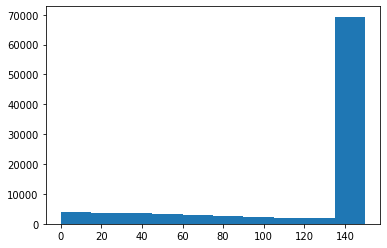

In [175]:
#Verifying if all chunks are of length less then 150
plt.hist(df_temp["combined"].apply(len))
plt.show()

In [168]:
#Formatting df_small
df_small_seq = df_small_seq[["index", "combined", "category"]]

In [169]:
#Creating consolidated dataframe 
df_final = df_small_seq.append(df_temp).reset_index(drop = True)

In [171]:
#BertSentence2Vec model is used get embeddings
class BertSentence2Vec(nn.Module):
    
    def __init__(self, bert_variant = "bert-base-uncased"):
        """
        Define the architecture of Bert Para2Vec
        
        Inputs:
            - bert_variant (str): BERT variant to use
        """
        super(BertSentence2Vec, self).__init__()
        self.bert_layer = BertModel.from_pretrained(bert_variant)
        
        # YOUR CODE HERE
        #raise NotImplementedError()
        
    def forward(self, input_ids, attn_mask):
        """
        Forward Passes the inputs through the network and obtains the prediction
        
        Inputs:
            - input_ids (torch.tensor): A torch tensor of shape [batch_size, seq_len]
                                        representing the sequence of token ids
            - attn_mask (torch.tensor): A torch tensor of shape [batch_size, seq_len]
                                        representing the attention mask such that padded tokens are 0 and rest 1
                                        
        Returns:
          - output (torch.tensor): A torch tensor of shape [batch_size,] obtained after passing the input to the network
                                        
        """
        bert_output = self.bert_layer(input_ids, attention_mask = attn_mask)
        #Getting the embeddings
        sentence_embedding = bert_output.pooler_output        
        
        return sentence_embedding 

In [173]:
#Creating dataloader and instantiating the model
torch.manual_seed(42)
sentences = df_final["combined"].values.tolist()
labels = df_final["category"].values.tolist()
dataset = BertDataset(sentences, labels, seq_len=150)
dataloader = DataLoader(dataset, batch_size=32)

model = BertSentence2Vec()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [174]:
#Generating embeddings
device = "cuda"
model = model.to(device)
with torch.no_grad():
  dff = pd.DataFrame(columns = np.arange(0,768,1))
  for batch in tqdm.tqdm(dataloader):
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.float().to(device)
    labels = labels.float().to(device)

    embedding = model(input_ids, attention_mask)
    df_vec = pd.DataFrame(embedding.cpu().numpy())
    dff = dff.append(df_vec)

100%|██████████| 3610/3610 [14:01<00:00,  4.29it/s]


In [76]:
#MLP Classifier
class classifier(nn.Module):
    
    def __init__(self, input_dim = 768):
        """
        Define the architecture of classifier.
        """
        super(classifier, self).__init__()
        output_dim = 5
        self.input_layer = nn.Linear(input_dim, 256)
        self.layer1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.25)
        self.layer2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.25)
        self.layer3 = nn.Linear(64, output_dim)
        self.dropout3 = nn.Dropout(0.25)
        self.softmax_layer = nn.LogSoftmax()
        

    def forward(self, x):
        """
        Forward Passes the inputs through the network and obtains the prediction
        
        Inputs:
            - x Embedding
                                        
        Returns:
          - output (torch.tensor): A torch tensor of shape [batch_size,] obtained after passing the input to the network
                                        
        """
        layer1 = self.dropout1(self.layer1(self.input_layer(x)))
        layer2 = self.dropout2(self.layer2(layer1))
        layer3 = self.dropout3(self.layer3(layer2))
        output = self.softmax_layer(layer3)
        
        return output.squeeze(-1) 

In [176]:
#Mapping embeddings to category and index
dff["category"] = list(df_final["category"])
dff["index"] = list(df_final["index"])


f_dict = {}
for i in range(768):
  f_dict[i] = 'sum'
f_dict['category'] = 'max'

In [178]:
#Aggregating/Pooling the embeddings
final_df = dff.groupby("index").agg(f_dict)

In [182]:
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,category
index,,,,,,,,,,,,,,,,,,,,,
0,-0.808581,-0.521799,-0.933632,0.753968,0.691683,-0.257352,0.825897,0.324172,-0.728082,-0.999970,...,-0.052831,0.955739,0.789242,-0.159437,-0.182844,0.547712,-0.864201,-0.621436,0.789245,0
1,-0.896474,-0.453156,-0.705106,0.795478,0.428873,-0.106675,0.901052,0.255664,-0.593922,-0.999989,...,-0.086375,0.909427,0.902675,0.133198,0.415424,0.509272,-0.517750,-0.682799,0.905028,2
2,-0.812739,-0.283650,-0.449288,0.676751,0.008511,-0.030799,0.858958,0.182227,-0.081731,-0.999939,...,0.538425,0.680782,0.840386,0.406986,0.458662,0.513434,-0.228937,-0.601373,0.845480,1
3,-0.818608,-0.364097,-0.625162,0.616065,0.367738,-0.203833,0.738299,0.294386,-0.319610,-0.999979,...,0.219702,0.687555,0.790432,0.072314,0.223585,0.589533,-0.478460,-0.669636,0.839418,1
4,-5.462592,-2.468406,-3.175258,4.110408,1.289395,-1.101952,5.102899,1.733524,-1.016906,-6.999469,...,1.569992,4.287838,5.511340,0.712182,3.125449,3.584841,-2.506014,-4.367422,5.651584,0


In [183]:
#Creating Dataloader for MLP Classifier
class embedding_dataset(Dataset):
    
    def __init__(self, embedding, labels):
        """

        """
        self.embedding = embedding
        self.labels = labels
        
    def __len__(self):
        """
        Returns the length of the dataset i.e. the number of reviews present in 
        the dataset
        """
        length = None
        
        # YOUR CODE HERE
        length = len(self.embedding)
        
        return length
    
    def __getitem__(self, idx):
        """
        """
        
        embedding = self.embedding[idx]
        label = self.labels[idx]
        
        return embedding, torch.tensor(label)

In [184]:
train_df, test_df = train_test_split(final_df, test_size = 0.2,\
                                     stratify = final_df["category"],\
                                     random_state = 42, shuffle = True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df, val_df = train_test_split(test_df, test_size=0.2, random_state = 42)
print(f"Number of Training Examples: {len(train_df)}")
print(f"Number of Validation Examples: {len(val_df)}")
print(f"Number of Test Examples: {len(test_df)}")

Number of Training Examples: 38284
Number of Validation Examples: 1915
Number of Test Examples: 7657


In [185]:
batch_size = 32

train_sentences, train_labels = train_df.iloc[:,:-1].values, train_df["category"].values
val_sentences, val_labels = val_df.iloc[:,:-1].values, val_df["category"].values
test_sentences, test_labels = test_df.iloc[:,:-1].values, test_df["category"].values

train_dataset = embedding_dataset(train_sentences, train_labels)
val_dataset = embedding_dataset(val_sentences, val_labels)
test_dataset = embedding_dataset(test_sentences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [186]:
def method2_evaluate(model, test_dataloader, threshold = 0.5, device = "cpu"):
    """
    Evaluates `model` on test dataset

    Inputs:
        - model (BertClassifierModel): Logistic Regression model to be evaluated
        - test_dataloader (torch.utils.DataLoader): A dataloader defined over the test dataset
        - threshold (float): Probability Threshold above which we consider label as 1 and 0 below

    Returns:
        - accuracy (float): Average accuracy over the test dataset 
    """

    model.to(device)
    model = model.eval() # Set model to evaluation model 
    accuracy = 0
    bucket_pred = []
    bucket_label = []

    with torch.no_grad():
      for test_batch in test_dataloader:
        embedding, labels = test_batch
        embedding = embedding.to(device).float()
        labels = labels.type(torch.LongTensor).to(device)

        # Step 1: Get probability predictions from the model and store it in `pred_probs`
        pred_probs = model(embedding)
  
        x_ = torch.topk(pred_probs,1).indices
        y_ = labels#torch.topk(labels,1).indices
        bucket_pred += x_.detach().tolist()
        bucket_label+= y_.detach().tolist()
        s = 0
        for i in range(len(x_)):
          if x_[i] == y_[i]:
            s+=1
        batch_accuracy = s/len(x_)

        # Step 2: Get accuracy of predictions and store it in `batch_accuracy`

        accuracy += batch_accuracy

      # Divide by number of batches to get average accuracy
      accuracy = accuracy / len(test_dataloader)

      return accuracy,np.array(bucket_pred).flatten(), np.array(bucket_label).flatten()

def method2_train(model, train_dataloader, val_dataloader,
          lr = 1e-5, num_epochs = 3,
          device = "cpu"):
    """
    Runs the training loop. 

    Inputs:
        - model : MLP Classifier
        - train_dataloader (torch.utils.DataLoader): A dataloader defined over the training dataset
        - val_dataloader (torch.utils.DataLoader): A dataloader defined over the validation dataset
        - lr (float): The learning rate for the optimizer
        - num_epochs (int): Number of epochs to train the model for.
        - device (str): Device to train the model on. Can be either 'cuda' (for using gpu) or 'cpu'

    Returns:
        - best_model : model corresponding to the highest validation accuracy (checked at the end of each epoch)
        - best_val_accuracy (float): Validation accuracy corresponding to the best epoch
    """
    epoch_loss = 0
    model = model.to(device)
    
    best_val_accuracy = float("-inf")
    best_model = None
    
    # 1. Define Loss function and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = Adam(model.parameters(), lr = lr)

    epoch_loss_bucket = []
    for epoch in range(num_epochs):
        model.train() # Since we are evaluating model at the end of every epoch, it is important to bring it back to train mode
        epoch_loss = 0
        
        # 2. Write Training Loop

        for train_batch in train_dataloader:
          optimizer.zero_grad()
          embedding, labels = train_batch

          embedding = embedding.to(device).float()
          labels = labels.type(torch.LongTensor).to(device)

          preds=model(embedding)

          loss = loss_fn(preds, labels)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
  
        
        epoch_loss = epoch_loss / len(train_dataloader)
        epoch_loss_bucket.append(epoch_loss)
        # 3. Evaluate on validation data by calling `evaluate` and store the validation accuracy in `val_accurracy`
        val_accuracy = 0

        val_accuracy,_,_ = method2_evaluate(model, val_dataloader, device ="cuda")
        
        # Model selection
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model) # Create a copy of model
        
        if (epoch % 10 == 0):
          print(f"Epoch {epoch} completed | Average Training Loss: {epoch_loss} | Validation Accuracy: {val_accuracy}")
    plt.plot(epoch_loss_bucket)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("Training Loss")
    plt.show()
    return best_model, best_val_accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 completed | Average Training Loss: 1.1659360561354914 | Validation Accuracy: 0.7216242283950617
Epoch 10 completed | Average Training Loss: 0.9363450866345077 | Validation Accuracy: 0.7273533950617284
Epoch 20 completed | Average Training Loss: 0.8731839454662033 | Validation Accuracy: 0.7700617283950617
Epoch 30 completed | Average Training Loss: 0.8505924457097511 | Validation Accuracy: 0.778491512345679
Epoch 40 completed | Average Training Loss: 0.8370321003366931 | Validation Accuracy: 0.789332561728395
Epoch 50 completed | Average Training Loss: 0.8242953340511274 | Validation Accuracy: 0.7845486111111111
Epoch 60 completed | Average Training Loss: 0.8100287702149317 | Validation Accuracy: 0.7876736111111111
Epoch 70 completed | Average Training Loss: 0.7999772865919641 | Validation Accuracy: 0.7899498456790124
Epoch 80 completed | Average Training Loss: 0.7991811844240951 | Validation Accuracy: 0.7908950617283951
Epoch 90 completed | Average Training Loss: 0.791385123579

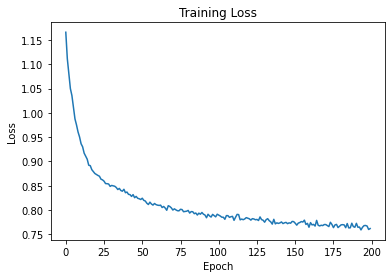

In [187]:
#Training the Model
model = classifier()
best_model, best_val_acc = method2_train(model, train_loader, val_loader, num_epochs = 200, device = "cuda")

In [188]:
#Test Accuracy
test_accuracy,bucket_pred,bucket_label = method2_evaluate(best_model, test_loader, threshold = 0.5, device = "cuda")
print(test_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.8060474537037037


              precision    recall  f1-score   support

           0       0.83      0.95      0.88      5431
           1       0.73      0.61      0.67      1555
           2       0.41      0.05      0.08       417
           3       0.59      0.22      0.32       151
           4       0.50      0.01      0.02       103

    accuracy                           0.81      7657
   macro avg       0.61      0.37      0.39      7657
weighted avg       0.78      0.81      0.77      7657



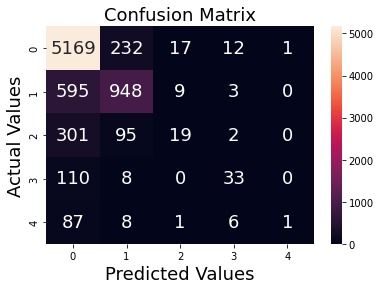

In [189]:
#Evaluating the model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(bucket_label, bucket_pred))
cm = confusion_matrix(bucket_label, bucket_pred)
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])
#Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 18}, fmt='.0f')
plt.title('Confusion Matrix', fontsize = 18)
plt.ylabel('Actual Values', fontsize = 18)
plt.xlabel('Predicted Values', fontsize = 18)
plt.show()

Model has better performance with good recall and precision on minority classes. Better accuracy towards the minority class indicate that model has generalised effectively